# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4890624/11490434 [===========>..................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 11:53 - loss: 0.6946

  26/1875 [..............................] - ETA: 3s - loss: 0.5733   

  52/1875 [..............................] - ETA: 3s - loss: 0.4896

  79/1875 [>.............................] - ETA: 3s - loss: 0.4425

 107/1875 [>.............................] - ETA: 3s - loss: 0.4115

 133/1875 [=>............................] - ETA: 3s - loss: 0.3908

 160/1875 [=>............................] - ETA: 3s - loss: 0.3743

 187/1875 [=>............................] - ETA: 3s - loss: 0.3608

 215/1875 [==>...........................] - ETA: 3s - loss: 0.3491

 243/1875 [==>...........................] - ETA: 3s - loss: 0.3391

 270/1875 [===>..........................] - ETA: 3s - loss: 0.3306

 296/1875 [===>..........................] - ETA: 3s - loss: 0.3233

 322/1875 [====>.........................] - ETA: 2s - loss: 0.3168

 349/1875 [====>.........................] - ETA: 2s - loss: 0.3106

 377/1875 [=====>........................] - ETA: 2s - loss: 0.3047

 403/1875 [=====>........................] - ETA: 2s - loss: 0.2997

 431/1875 [=====>........................] - ETA: 2s - loss: 0.2948

 459/1875 [======>.......................] - ETA: 2s - loss: 0.2902

 489/1875 [======>.......................] - ETA: 2s - loss: 0.2857

 518/1875 [=======>......................] - ETA: 2s - loss: 0.2816

 544/1875 [=======>......................] - ETA: 2s - loss: 0.2782

 571/1875 [========>.....................] - ETA: 2s - loss: 0.2748

 599/1875 [========>.....................] - ETA: 2s - loss: 0.2715

 628/1875 [=========>....................] - ETA: 2s - loss: 0.2683

 655/1875 [=========>....................] - ETA: 2s - loss: 0.2654

 679/1875 [=========>....................] - ETA: 2s - loss: 0.2630

 705/1875 [==========>...................] - ETA: 2s - loss: 0.2605

 732/1875 [==========>...................] - ETA: 2s - loss: 0.2581

 759/1875 [===========>..................] - ETA: 2s - loss: 0.2557

 787/1875 [===========>..................] - ETA: 2s - loss: 0.2533

 814/1875 [============>.................] - ETA: 2s - loss: 0.2512

 843/1875 [============>.................] - ETA: 1s - loss: 0.2489

 871/1875 [============>.................] - ETA: 1s - loss: 0.2469

 900/1875 [=============>................] - ETA: 1s - loss: 0.2448

 930/1875 [=============>................] - ETA: 1s - loss: 0.2427

 959/1875 [==============>...............] - ETA: 1s - loss: 0.2408

 987/1875 [==============>...............] - ETA: 1s - loss: 0.2390

1013/1875 [===============>..............] - ETA: 1s - loss: 0.2374

1041/1875 [===============>..............] - ETA: 1s - loss: 0.2358

1070/1875 [================>.............] - ETA: 1s - loss: 0.2341

1099/1875 [================>.............] - ETA: 1s - loss: 0.2325

1129/1875 [=================>............] - ETA: 1s - loss: 0.2309

1157/1875 [=================>............] - ETA: 1s - loss: 0.2294

1183/1875 [=================>............] - ETA: 1s - loss: 0.2281

1210/1875 [==================>...........] - ETA: 1s - loss: 0.2268

1237/1875 [==================>...........] - ETA: 1s - loss: 0.2255

1258/1875 [===================>..........] - ETA: 1s - loss: 0.2245

1285/1875 [===================>..........] - ETA: 1s - loss: 0.2233

1312/1875 [===================>..........] - ETA: 1s - loss: 0.2221

1337/1875 [====================>.........] - ETA: 1s - loss: 0.2210

1366/1875 [====================>.........] - ETA: 0s - loss: 0.2198

1395/1875 [=====================>........] - ETA: 0s - loss: 0.2186

1426/1875 [=====================>........] - ETA: 0s - loss: 0.2173

1455/1875 [======================>.......] - ETA: 0s - loss: 0.2162

1485/1875 [======================>.......] - ETA: 0s - loss: 0.2150

1511/1875 [=======================>......] - ETA: 0s - loss: 0.2141

1538/1875 [=======================>......] - ETA: 0s - loss: 0.2131

1564/1875 [========================>.....] - ETA: 0s - loss: 0.2121

1586/1875 [========================>.....] - ETA: 0s - loss: 0.2114

1615/1875 [========================>.....] - ETA: 0s - loss: 0.2104

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1673/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1706/1875 [==========================>...] - ETA: 0s - loss: 0.2074

1738/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1764/1875 [===========================>..] - ETA: 0s - loss: 0.2056

1790/1875 [===========================>..] - ETA: 0s - loss: 0.2048

1816/1875 [============================>.] - ETA: 0s - loss: 0.2040

1844/1875 [============================>.] - ETA: 0s - loss: 0.2032

1871/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2023


Epoch 2/5
   1/1875 [..............................] - ETA: 8s - loss: 0.1075

  28/1875 [..............................] - ETA: 3s - loss: 0.1091

  50/1875 [..............................] - ETA: 3s - loss: 0.1093

  77/1875 [>.............................] - ETA: 3s - loss: 0.1091

 103/1875 [>.............................] - ETA: 3s - loss: 0.1091

 127/1875 [=>............................] - ETA: 3s - loss: 0.1091

 151/1875 [=>............................] - ETA: 3s - loss: 0.1091

 179/1875 [=>............................] - ETA: 3s - loss: 0.1090

 208/1875 [==>...........................] - ETA: 3s - loss: 0.1090

 237/1875 [==>...........................] - ETA: 3s - loss: 0.1089

 264/1875 [===>..........................] - ETA: 3s - loss: 0.1088

 290/1875 [===>..........................] - ETA: 3s - loss: 0.1088

 319/1875 [====>.........................] - ETA: 2s - loss: 0.1087

 345/1875 [====>.........................] - ETA: 2s - loss: 0.1087

 373/1875 [====>.........................] - ETA: 2s - loss: 0.1086

 400/1875 [=====>........................] - ETA: 2s - loss: 0.1086

 429/1875 [=====>........................] - ETA: 2s - loss: 0.1085

 457/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 487/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 518/1875 [=======>......................] - ETA: 2s - loss: 0.1083

 550/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 580/1875 [========>.....................] - ETA: 2s - loss: 0.1081

 607/1875 [========>.....................] - ETA: 2s - loss: 0.1081

 635/1875 [=========>....................] - ETA: 2s - loss: 0.1080

 661/1875 [=========>....................] - ETA: 2s - loss: 0.1079

 688/1875 [==========>...................] - ETA: 2s - loss: 0.1079

 713/1875 [==========>...................] - ETA: 2s - loss: 0.1078

 739/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 766/1875 [===========>..................] - ETA: 2s - loss: 0.1077

 791/1875 [===========>..................] - ETA: 2s - loss: 0.1076

 819/1875 [============>.................] - ETA: 1s - loss: 0.1076

 847/1875 [============>.................] - ETA: 1s - loss: 0.1075

 874/1875 [============>.................] - ETA: 1s - loss: 0.1074

 903/1875 [=============>................] - ETA: 1s - loss: 0.1074

 931/1875 [=============>................] - ETA: 1s - loss: 0.1073

 962/1875 [==============>...............] - ETA: 1s - loss: 0.1072

 987/1875 [==============>...............] - ETA: 1s - loss: 0.1072

1012/1875 [===============>..............] - ETA: 1s - loss: 0.1071

1031/1875 [===============>..............] - ETA: 1s - loss: 0.1071

1057/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1079/1875 [================>.............] - ETA: 1s - loss: 0.1070

1101/1875 [================>.............] - ETA: 1s - loss: 0.1069

1124/1875 [================>.............] - ETA: 1s - loss: 0.1069

1144/1875 [=================>............] - ETA: 1s - loss: 0.1068

1163/1875 [=================>............] - ETA: 1s - loss: 0.1068

1188/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1208/1875 [==================>...........] - ETA: 1s - loss: 0.1067

1232/1875 [==================>...........] - ETA: 1s - loss: 0.1067

1256/1875 [===================>..........] - ETA: 1s - loss: 0.1066

1280/1875 [===================>..........] - ETA: 1s - loss: 0.1066

1300/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1323/1875 [====================>.........] - ETA: 1s - loss: 0.1065

1349/1875 [====================>.........] - ETA: 1s - loss: 0.1065

1371/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1397/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1418/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1442/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1469/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1493/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1521/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1546/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1572/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1600/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1629/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1658/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1684/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1709/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1738/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1768/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1799/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1828/1875 [============================>.] - ETA: 0s - loss: 0.1056

1852/1875 [============================>.] - ETA: 0s - loss: 0.1056

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1055


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0939

  20/1875 [..............................] - ETA: 5s - loss: 0.0964

  46/1875 [..............................] - ETA: 4s - loss: 0.0969

  72/1875 [>.............................] - ETA: 3s - loss: 0.0970

  99/1875 [>.............................] - ETA: 3s - loss: 0.0973

 125/1875 [=>............................] - ETA: 3s - loss: 0.0974

 153/1875 [=>............................] - ETA: 3s - loss: 0.0975

 177/1875 [=>............................] - ETA: 3s - loss: 0.0976

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0976

 222/1875 [==>...........................] - ETA: 3s - loss: 0.0976

 248/1875 [==>...........................] - ETA: 3s - loss: 0.0977

 272/1875 [===>..........................] - ETA: 3s - loss: 0.0977

 299/1875 [===>..........................] - ETA: 3s - loss: 0.0977

 326/1875 [====>.........................] - ETA: 3s - loss: 0.0977

 353/1875 [====>.........................] - ETA: 3s - loss: 0.0977

 380/1875 [=====>........................] - ETA: 3s - loss: 0.0978

 407/1875 [=====>........................] - ETA: 2s - loss: 0.0978

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0978

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 488/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 542/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 599/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 627/1875 [=========>....................] - ETA: 2s - loss: 0.0978

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0978

 684/1875 [=========>....................] - ETA: 2s - loss: 0.0978

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0978

 735/1875 [==========>...................] - ETA: 2s - loss: 0.0978

 760/1875 [===========>..................] - ETA: 2s - loss: 0.0978

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0978

 808/1875 [===========>..................] - ETA: 2s - loss: 0.0978

 832/1875 [============>.................] - ETA: 2s - loss: 0.0978

 854/1875 [============>.................] - ETA: 2s - loss: 0.0978

 882/1875 [=============>................] - ETA: 1s - loss: 0.0978

 903/1875 [=============>................] - ETA: 1s - loss: 0.0978

 925/1875 [=============>................] - ETA: 1s - loss: 0.0978

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 997/1875 [==============>...............] - ETA: 1s - loss: 0.0978

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0977

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0977

1075/1875 [================>.............] - ETA: 1s - loss: 0.0977

1100/1875 [================>.............] - ETA: 1s - loss: 0.0977

1124/1875 [================>.............] - ETA: 1s - loss: 0.0977

1147/1875 [=================>............] - ETA: 1s - loss: 0.0977

1172/1875 [=================>............] - ETA: 1s - loss: 0.0977

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1243/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1307/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0977

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0977

1380/1875 [=====================>........] - ETA: 1s - loss: 0.0977

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1455/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1481/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1505/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1532/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1587/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0976

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1817/1875 [============================>.] - ETA: 0s - loss: 0.0976

1840/1875 [============================>.] - ETA: 0s - loss: 0.0976

1868/1875 [============================>.] - ETA: 0s - loss: 0.0976

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0976


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1009

  24/1875 [..............................] - ETA: 4s - loss: 0.0978

  47/1875 [..............................] - ETA: 4s - loss: 0.0965

  74/1875 [>.............................] - ETA: 3s - loss: 0.0960

 101/1875 [>.............................] - ETA: 3s - loss: 0.0960

 125/1875 [=>............................] - ETA: 3s - loss: 0.0959

 146/1875 [=>............................] - ETA: 3s - loss: 0.0959

 172/1875 [=>............................] - ETA: 3s - loss: 0.0959

 200/1875 [==>...........................] - ETA: 3s - loss: 0.0959

 223/1875 [==>...........................] - ETA: 3s - loss: 0.0959

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0959

 267/1875 [===>..........................] - ETA: 3s - loss: 0.0959

 290/1875 [===>..........................] - ETA: 3s - loss: 0.0959

 313/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 337/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 358/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 382/1875 [=====>........................] - ETA: 3s - loss: 0.0959

 406/1875 [=====>........................] - ETA: 3s - loss: 0.0959

 435/1875 [=====>........................] - ETA: 3s - loss: 0.0959

 457/1875 [======>.......................] - ETA: 3s - loss: 0.0959

 481/1875 [======>.......................] - ETA: 3s - loss: 0.0959

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 530/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 555/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 647/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 669/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 694/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 716/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 735/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 760/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 786/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 833/1875 [============>.................] - ETA: 2s - loss: 0.0960

 859/1875 [============>.................] - ETA: 2s - loss: 0.0960

 885/1875 [=============>................] - ETA: 2s - loss: 0.0960

 913/1875 [=============>................] - ETA: 2s - loss: 0.0960

 940/1875 [==============>...............] - ETA: 2s - loss: 0.0960

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1020/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1072/1875 [================>.............] - ETA: 1s - loss: 0.0960

1099/1875 [================>.............] - ETA: 1s - loss: 0.0960

1128/1875 [=================>............] - ETA: 1s - loss: 0.0960

1156/1875 [=================>............] - ETA: 1s - loss: 0.0960

1182/1875 [=================>............] - ETA: 1s - loss: 0.0960

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1237/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1281/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1349/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1376/1875 [=====================>........] - ETA: 1s - loss: 0.0960

1400/1875 [=====================>........] - ETA: 1s - loss: 0.0960

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1817/1875 [============================>.] - ETA: 0s - loss: 0.0959

1843/1875 [============================>.] - ETA: 0s - loss: 0.0959

1868/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0965

  26/1875 [..............................] - ETA: 3s - loss: 0.0966

  56/1875 [..............................] - ETA: 3s - loss: 0.0959

  85/1875 [>.............................] - ETA: 3s - loss: 0.0956

 112/1875 [>.............................] - ETA: 3s - loss: 0.0956

 138/1875 [=>............................] - ETA: 3s - loss: 0.0955

 164/1875 [=>............................] - ETA: 3s - loss: 0.0954

 189/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 214/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 239/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0954

 294/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 323/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 376/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 398/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 424/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 538/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 560/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 615/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 700/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 728/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 758/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 785/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 812/1875 [===========>..................] - ETA: 2s - loss: 0.0955

 840/1875 [============>.................] - ETA: 2s - loss: 0.0955

 869/1875 [============>.................] - ETA: 1s - loss: 0.0955

 896/1875 [=============>................] - ETA: 1s - loss: 0.0955

 917/1875 [=============>................] - ETA: 1s - loss: 0.0955

 940/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 963/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 990/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1069/1875 [================>.............] - ETA: 1s - loss: 0.0955

1095/1875 [================>.............] - ETA: 1s - loss: 0.0955

1122/1875 [================>.............] - ETA: 1s - loss: 0.0955

1149/1875 [=================>............] - ETA: 1s - loss: 0.0955

1177/1875 [=================>............] - ETA: 1s - loss: 0.0955

1201/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1248/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1274/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1354/1875 [====================>.........] - ETA: 1s - loss: 0.0954

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1406/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1776/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1823/1875 [============================>.] - ETA: 0s - loss: 0.0954

1845/1875 [============================>.] - ETA: 0s - loss: 0.0954

1866/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

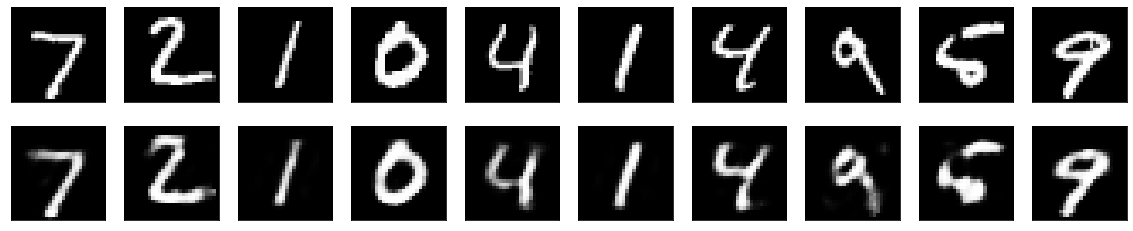

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
